# Preparação do ambiente

## Bibliotecas

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pandas as pd
import re
import unidecode

from datetime import datetime
from joblib import load

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from string import punctuation

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## Constantes e funções auxiliares

In [3]:
FILE_MARKETPLACES = '../datasets/label_issues/20240423/results/marketplaces.parquet'
FILE_SUPERVISAO_MERCADO = '../datasets/supervisao_mercado/supervisao_mercado.xlsx'
FILE_MODEL_CLF3 = '../experimentos/assets/exp_clf3_model.joblib'

FILE_HYPER_PARAMETERS = '../datasets/gs_hyper_paramenters_classifiers.json'

N_JOBS = -1

In [4]:
def load_file_mercado(file_mercado=FILE_SUPERVISAO_MERCADO):
    dict_df_mercado = pd.read_excel(
    file_mercado,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'titulo', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

    df_list = []
    for key in dict_df_mercado.keys():
        df = dict_df_mercado[key]
        df['marketplace'] = key
        df_list.append(df)
        
    df_mercado = pd.concat(df_list)
    df_mercado = df_mercado.dropna()
    df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)
    
    map_marketplaces = {
        'Amazon': 'Amazon', 
        'Americanas': 'Lojas Americanas',
        'CasasBahia': 'Casas Bahia',
        'Magalu': 'Magazine Luiza', 
        'MercadoLivre': 'Mercado Livre'
    }
    
    df_mercado['marketplace'] = df_mercado['marketplace'].map(map_marketplaces)

    return df_mercado

In [ ]:
def save_best_params():
    
    _best_params = {
        'name': pipe['clf'].__class__.__name__,
        'best_params': json.dumps(gs.best_params_),
        'mean_fit_time': gs.cv_results_['mean_fit_time'].mean(),
        'timestamp': datetime.now().timestamp(),
        'train_auc': gs.best_score_,
        'train_accuracy': gs.score(X_test,y_test),
    }

    # test accuracy and roc_auc_score
    test_accuracy = gs.best_estimator_.score(X_test,y_test)
    valid_accuracy = gs.best_estimator_.score(X_valid,y_valid)
    
    if hasattr(gs.best_estimator_['clf'],'predict_proba'):
        y_test_score = gs.best_estimator_.predict_proba(X_test)[:,1]
        y_valid_score = gs.best_estimator_.predict_proba(X_valid)[:,1]
    else:
        y_test_score = gs.best_estimator_.decision_function(X_test)
        y_valid_score = gs.best_estimator_.decision_function(X_valid)
        
    test_auc = roc_auc_score(y_test,y_test_score)
    valid_auc = roc_auc_score(y_valid,y_valid_score)

    _best_params['test_auc'] = test_auc
    _best_params['test_accuracy'] = test_accuracy

    _best_params['valid_auc'] = valid_auc
    _best_params['valid_accuracy'] = valid_accuracy
    
    if osp.exists(FILE_HYPER_PARAMETERS):
        with open(FILE_HYPER_PARAMETERS, 'r') as f:
            clf_best_params = json.load(f) 
    else:
        clf_best_params = []
    
    clf_best_params.append(_best_params)
    
    df = pd.DataFrame(clf_best_params)
    df = df.sort_values(by=['test_auc','test_accuracy', 'timestamp'], ascending=False).reset_index(drop=True)
    df = df.drop_duplicates(subset='name',keep='first')
    
    clf_best_params = df.to_dict('records')
    with open(FILE_HYPER_PARAMETERS, 'w+') as f:
        json.dump(clf_best_params,f,indent=2)
    
    return df

In [30]:
def load_best_params():

    with open(FILE_HYPER_PARAMETERS) as f:
        clf_best_params = json.load(f)
        
    return pd.DataFrame(clf_best_params)

# Carga e prepação dos dados

In [10]:
df_marketplaces = pd.read_parquet(FILE_MARKETPLACES)
df_mercado = load_file_mercado()

# reduzir a base de dados para construir o notebook
# df_marketplaces = df_marketplaces.sample(10)

# conjunto de dados
docs_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['titulo'].values
targets_marketplaces = df_marketplaces[df_marketplaces['passivel_homologacao']<2]['passivel_homologacao'].values

# Split data to keep experiment results comparable
X_train, X_test, y_train, y_test = train_test_split(
    docs_marketplaces, targets_marketplaces,
    test_size=0.25, 
    random_state=724
)

X_valid, y_valid = df_mercado['titulo'].values, df_mercado['passivel_homologacao'].values

# Análise


https://levity.ai/blog/text-classifiers-in-machine-learning-a-practical-guide

## Ajustando hiperparâmetros dos algoritmos

In [11]:
start_time = datetime.now()

### DummyClassifier

In [12]:
%%time
clf = DummyClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__strategy": ('most_frequent', 'prior', 'stratified', 'uniform', 'constant'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 625 ms
Wall time: 12.7 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


### NaiveBayes

#### BernoulliNB

In [14]:
%%time
clf = BernoulliNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)

save_best_params()

CPU times: total: 609 ms
Wall time: 2.9 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
1,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


#### ComplementNB

In [15]:
%%time
clf = ComplementNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 766 ms
Wall time: 2.88 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
1,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
2,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


In [16]:
hasattr(gs.best_estimator_['clf'],'decision_function')

False

#### MultinomialNB

In [17]:
%%time
clf = MultinomialNB()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe, parameter_grid, scoring=scoring, refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 656 ms
Wall time: 2.97 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
1,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
2,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
3,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


### KNeighborsClassifier

In [18]:
%%time
clf = KNeighborsClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_neighbors": (3, 5, 10),
    "clf__p": (1, 2)
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 29.5 s
Wall time: 23.8 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
1,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
2,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
3,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
4,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


### Linear models

#### SGDClassifier

In [19]:
%%time
clf = SGDClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__alpha": np.logspace(-6, 6, 13),
    "clf__loss": ('hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'),
    "clf__penalty": ('l1', 'l2', 'elasticnet'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 10.5 s
Wall time: 45.5 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,SGDClassifier,0.969619,0.967478,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.919292,0.969619,0.453436,1.727109e+09,0.919292,0.969619
1,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
2,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
3,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
4,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
5,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


#### LogisticRegression

In [20]:
%%time
clf = LogisticRegression(solver='liblinear')

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__C": np.logspace(-5, 5, 11),
    "clf__penalty": ('l1', 'l2'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 1.92 s
Wall time: 6.53 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,LogisticRegression,0.969649,0.967771,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.916762,0.969649,0.509357,1.727109e+09,0.916762,0.969649
1,SGDClassifier,0.969619,0.967478,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.919292,0.969619,0.453436,1.727109e+09,0.919292,0.969619
2,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
3,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
4,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
5,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
6,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


#### RidgeClassifier

In [21]:
%%time
clf = RidgeClassifier(fit_intercept=False)

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__solver": ('cholesky', 'sparse_cg', 'sag', 'saga'),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 859 ms
Wall time: 27.7 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,LogisticRegression,0.969649,0.967771,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.916762,0.969649,0.509357,1.727109e+09,0.916762,0.969649
1,SGDClassifier,0.969619,0.967478,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.919292,0.969619,0.453436,1.727109e+09,0.919292,0.969619
2,RidgeClassifier,0.966690,0.966041,"{""clf__solver"": ""sparse_cg""}",0.915153,0.966690,7.068036,1.727109e+09,0.915153,0.966690
3,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
4,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
5,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
6,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
7,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


### SVM

#### LinearSVC

In [22]:
%%time
clf = LinearSVC()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__loss": ('hinge', 'squared_hinge'),
    "clf__C": np.logspace(-5,0,6),
    "clf__tol": np.logspace(-5,0,6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 3.39 s
Wall time: 16.4 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,LogisticRegression,0.969649,0.967771,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.916762,0.969649,0.509357,1.727109e+09,0.916762,0.969649
1,SGDClassifier,0.969619,0.967478,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.919292,0.969619,0.453436,1.727109e+09,0.919292,0.969619
2,LinearSVC,0.968384,0.966938,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.919522,0.968384,0.415437,1.727109e+09,0.919522,0.968384
3,RidgeClassifier,0.966690,0.966041,"{""clf__solver"": ""sparse_cg""}",0.915153,0.966690,7.068036,1.727109e+09,0.915153,0.966690
4,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
5,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
6,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
7,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
8,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


#### NuSVC

In [23]:
%%time
clf = NuSVC()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__nu": (0.1, 0.25, 0.5, 0.75, 1),
    "clf__kernel": ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed'),
    "clf__tol": np.logspace(-5,0,6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

### Tree

#### DecisionTreeClassifier

In [24]:
%%time
clf = DecisionTreeClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__splitter": ('best', 'random'),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 1.12 s
Wall time: 6.94 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,LogisticRegression,0.969649,0.967771,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.916762,0.969649,0.509357,1.727109e+09,0.916762,0.969649
1,SGDClassifier,0.969619,0.967478,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.919292,0.969619,0.453436,1.727109e+09,0.919292,0.969619
2,LinearSVC,0.968384,0.966938,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.919522,0.968384,0.415437,1.727109e+09,0.919522,0.968384
3,RidgeClassifier,0.966690,0.966041,"{""clf__solver"": ""sparse_cg""}",0.915153,0.966690,7.068036,1.727109e+09,0.915153,0.966690
4,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
5,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
6,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
7,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
8,DecisionTreeClassifier,0.838031,0.830398,"{""clf__criterion"": ""entropy"", ""clf__max_featur...",0.844792,0.838031,1.013693,1.727109e+09,0.844792,0.838031
9,DummyClassifier,0.493751,0.500228,"{""clf__strategy"": ""stratified""}",0.520579,0.509106,0.356684,1.727109e+09,NaN,NaN


#### Extremely randomized tree 

In [25]:
%%time
clf = ExtraTreeClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__splitter": ('best', 'random'),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 922 ms
Wall time: 6.53 s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,LogisticRegression,0.969649,0.967771,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.916762,0.969649,0.509357,1.727109e+09,0.916762,0.969649
1,SGDClassifier,0.969619,0.967478,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.919292,0.969619,0.453436,1.727109e+09,0.919292,0.969619
2,LinearSVC,0.968384,0.966938,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.919522,0.968384,0.415437,1.727109e+09,0.919522,0.968384
3,RidgeClassifier,0.966690,0.966041,"{""clf__solver"": ""sparse_cg""}",0.915153,0.966690,7.068036,1.727109e+09,0.915153,0.966690
4,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
5,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
6,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
7,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
8,ExtraTreeClassifier,0.842229,0.834086,"{""clf__criterion"": ""entropy"", ""clf__max_featur...",0.846861,0.842229,0.963045,1.727109e+09,0.846861,0.842229
9,DecisionTreeClassifier,0.838031,0.830398,"{""clf__criterion"": ""entropy"", ""clf__max_featur...",0.844792,0.838031,1.013693,1.727109e+09,0.844792,0.838031


### Ensemble

#### RandomForestClassifier

In [26]:
%%time
clf = RandomForestClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_estimators": (10, 100, 500),
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_features": ('sqrt', 'log2')
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

#### AdaBoostClassifier

In [27]:
%%time
clf = AdaBoostClassifier()

vectorizer = TfidfVectorizer()
pipe = Pipeline(steps = [('vectorizer',vectorizer),('clf',clf)])

parameter_grid = {
    "clf__n_estimators": (50, 100, 500),
    "clf__learning_rate": np.logspace(-5, 0, 6),
}
scoring = {"AUC": "roc_auc"}

gs = GridSearchCV(pipe,parameter_grid,scoring=scoring,refit='AUC', n_jobs=N_JOBS)
gs.fit(X_train, y_train)
save_best_params()

CPU times: total: 16.3 s
Wall time: 4min 4s


,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,LogisticRegression,0.969649,0.967771,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.916762,0.969649,0.509357,1.727109e+09,0.916762,0.969649
1,SGDClassifier,0.969619,0.967478,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.919292,0.969619,0.453436,1.727109e+09,0.919292,0.969619
2,LinearSVC,0.968384,0.966938,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.919522,0.968384,0.415437,1.727109e+09,0.919522,0.968384
3,RidgeClassifier,0.966690,0.966041,"{""clf__solver"": ""sparse_cg""}",0.915153,0.966690,7.068036,1.727109e+09,0.915153,0.966690
4,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
5,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
6,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
7,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
8,AdaBoostClassifier,0.951963,0.948187,"{""clf__learning_rate"": 0.1, ""clf__n_estimators...",0.882042,0.951963,23.367744,1.727110e+09,0.882042,0.951963
9,ExtraTreeClassifier,0.842229,0.834086,"{""clf__criterion"": ""entropy"", ""clf__max_featur...",0.846861,0.842229,0.963045,1.727109e+09,0.846861,0.842229


## Consolidar e exibir resultados

### Tempo de treinamento

In [28]:
elapsed_time = datetime.now() - start_time
print('Total trainning time: {} seconds'.format(int(elapsed_time.total_seconds())))
print('Total trainning time: {} minutes'.format(int(elapsed_time.total_seconds()//60)))

Total trainning time: 400 seconds
Total trainning time: 6 minutes


### Scores

In [31]:
df = load_best_params()
df

,name,train_accuracy,train_auc,best_params,test_accuracy,test_auc,mean_fit_time,timestamp,valid_accuracy,valid_auc
0,LogisticRegression,0.969649,0.967771,"{""clf__C"": 10.0, ""clf__penalty"": ""l2""}",0.916762,0.969649,0.509357,1.727109e+09,0.916762,0.969649
1,SGDClassifier,0.969619,0.967478,"{""clf__alpha"": 1e-05, ""clf__loss"": ""log_loss"",...",0.919292,0.969619,0.453436,1.727109e+09,0.919292,0.969619
2,LinearSVC,0.968384,0.966938,"{""clf__C"": 1.0, ""clf__loss"": ""squared_hinge"", ...",0.919522,0.968384,0.415437,1.727109e+09,0.919522,0.968384
3,RidgeClassifier,0.966690,0.966041,"{""clf__solver"": ""sparse_cg""}",0.915153,0.966690,7.068036,1.727109e+09,0.915153,0.966690
4,ComplementNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.902046,0.957040,0.334359,1.727109e+09,0.902046,0.957040
5,MultinomialNB,0.957040,0.958971,"{""clf__alpha"": 1.0}",0.894229,0.957040,0.330310,1.727109e+09,0.894229,0.957040
6,KNeighborsClassifier,0.956598,0.953876,"{""clf__n_neighbors"": 10, ""clf__p"": 2}",0.906875,0.956598,0.315271,1.727109e+09,0.906875,0.956598
7,BernoulliNB,0.953859,0.956049,"{""clf__alpha"": 1.0}",0.895838,0.953859,0.324915,1.727109e+09,0.895838,0.953859
8,AdaBoostClassifier,0.951963,0.948187,"{""clf__learning_rate"": 0.1, ""clf__n_estimators...",0.882042,0.951963,23.367744,1.727110e+09,0.882042,0.951963
9,ExtraTreeClassifier,0.842229,0.834086,"{""clf__criterion"": ""entropy"", ""clf__max_featur...",0.846861,0.842229,0.963045,1.727109e+09,0.846861,0.842229


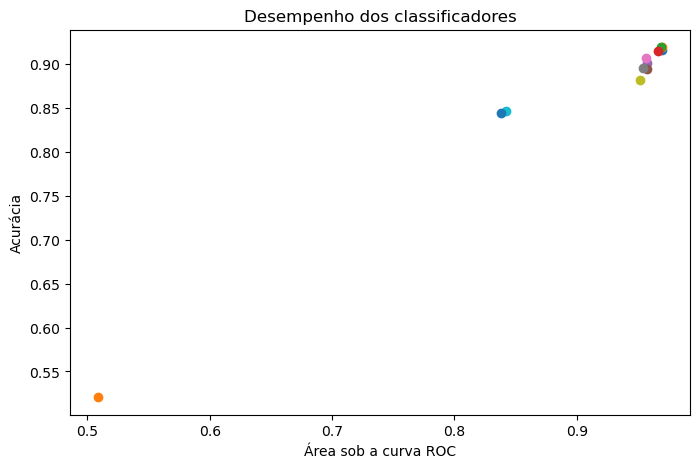

In [32]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

for record in df.to_dict('records'):
    label = record['name']
    x = record['test_auc']
    y = record['test_accuracy']
    _=ax.scatter(x,y, label=label)

ax.set_xlabel('Área sob a curva ROC')
ax.set_ylabel('Acurácia')
ax.set_title('Desempenho dos classificadores')
ax.legend()
plt.show()


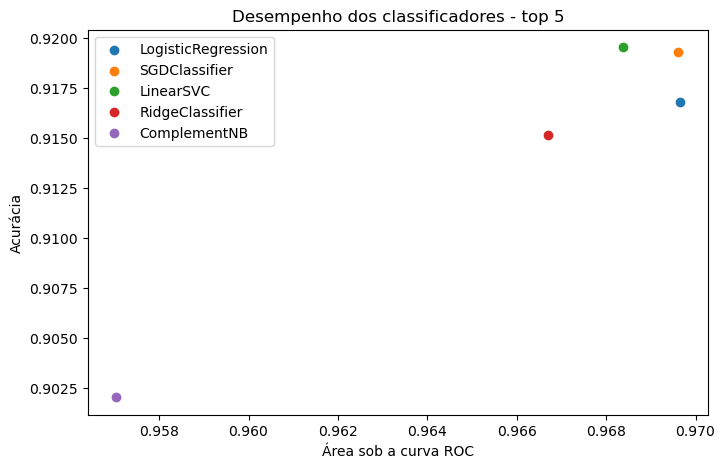

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.set_xlim(0,1)
# ax.set_ylim(0,1)

for record in df.head(5).to_dict('records'):
    label = record['name']
    x = record['test_auc']
    y = record['test_accuracy']
    _=ax.scatter(x,y, label=label)

ax.set_xlabel('Área sob a curva ROC')
ax.set_ylabel('Acurácia')
ax.set_title('Desempenho dos 5 melhores classificadores')
ax.legend()
plt.show()